In [40]:
import tensorflow as tf
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.13.0-rc1
2.2.4


In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


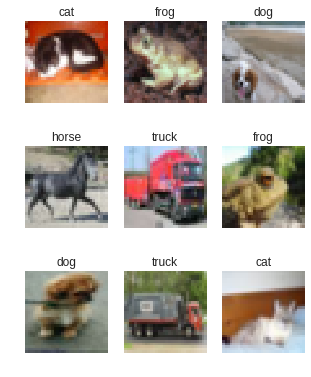

In [42]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]
cols = 3
rows = 3
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [0]:
# normalize inputs
x_train2 = x_train/255-0.5 
x_test2 = x_test/255-0.5 

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train,10)
y_test2 = keras.utils.to_categorical(y_test,10)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
   
    model.add(Conv2D(64, kernel_size=4,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model
    

In [0]:
INIT_LR = 1e-3  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 40

model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.95 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [47]:
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=40,
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()]
)
score = model.evaluate(x_test2, y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Learning rate: 0.001
Learning rate: 0.00095
Learning rate: 0.0009025
Learning rate: 0.000857375
Learning rate: 0.00081450626
Learning rate: 0.0007737809
Learning rate: 0.0007350919
Learning rate: 0.0006983373
Learning rate: 0.0006634204
Learning rate: 0.0006302494
Learning rate: 0.0005987369
Learning rate: 0.0005688001
Learning rate: 0.0005403601
Learning rate: 0.0005133421
Learning rate: 0.000487675
Learning rate: 0.00046329122
Learning rate: 0.00044012666
Learning rate: 0.00041812033
Learning rate: 0.00039721432
Learning rate: 0.0003773536
Learning rate: 0.00035848594
Learning rate: 0.00034056162
Learning rate: 0.00032353355
Learning rate: 0.00030735688
Learning rate: 0.000291989
Learning rate: 0.00027738957
Learning rate: 0.0002635201
Learning rate: 0.00025034408
Learning rate: 0.00023782688
Learning rate: 0.00022593554
Learning rate: 0.00021463877
Learning rate: 0.00020390682
Learning rate: 0.00019371149
Learning rate: 0.0001840259
Learning rate: 0.00017482461
Learning rate: 0.0001

In [48]:
!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555


  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-7ihwdjeo
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_608f27/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize


In [0]:
from keras.callbacks import TensorBoard
from skopt import gp_minimize, dump, load
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

In [0]:
from keras.optimizers import Adam
def create_model(learning_rate, kernel_size, num_dense_layers):
    # Start construction of a Keras Sequential model.
    model = Sequential()
  
    model.add(Conv2D(64, kernel_size=4,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
    model.add(Conv2D(64, kernel_size=4,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Flatten())
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(64,
                        activation='relu',
                        name=name))
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])    
    return model

In [0]:
def log_dir_name(learning_rate,
                 kernel_size,
                 num_dense_layers):
    # The dir-name for the TensorBoard log-dir.
    s = os.path.join(log_path, "lr_{0:.0e}_kernel_{1}_dense_{2}/")
    
    log_dir = s.format(learning_rate,
                       kernel_size,
                       num_dense_layers)
    return log_dir

In [0]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                             name='learning_rate')
dim_kernel_size = Integer(low=3, high=5, name='kernel_size')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')

dimensions = [dim_learning_rate, dim_kernel_size, dim_num_dense_layers]

In [0]:
import os
log_path = './mnist_skopt_log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
result_path = './mnist_skopt_result/'
if not os.path.exists(result_path):
    os.makedirs(result_path)
path_best_model = os.path.join(result_path+'best_model.keras')
best_accuracy = 0.0

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, kernel_size, num_dense_layers):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('kernel_size:', kernel_size)
    print('num_dense_layers:', num_dense_layers)
    print()
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate, kernel_size,  num_dense_layers)
     
    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, kernel_size,  num_dense_layers)
     
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
    
    # Use Keras to train the model.
    history = model.fit(x_train2, y_train2,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(x_test2, y_test2),
                        callbacks=[callback_log])
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [55]:
# initial hyperparameters for search
default_parameters = [1e-4, 3, 1]

# search by Gaussian Process Optimization
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11, # min n_calls=11
                            x0=default_parameters)

learning rate: 1.0e-04
kernel_size: 3
num_dense_layers: 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 24s 487us/step - loss: 1.6243 - acc: 0.4251 - val_loss: 1.4120 - val_acc: 0.4940
Epoch 2/20
50000/50000 [==============================] - 24s 481us/step - loss: 1.3088 - acc: 0.5375 - val_loss: 1.2431 - val_acc: 0.5606
Epoch 3/20
50000/50000 [==============================] - 24s 481us/step - loss: 1.1827 - acc: 0.5871 - val_loss: 1.1633 - val_acc: 0.5884
Epoch 4/20
50000/50000 [==============================] - 24s 480us/step - loss: 1.0874 - acc: 0.6208 - val_loss: 1.1118 - val_acc: 0.6053
Epoch 5/20
50000/50000 [==============================] - 24s 480us/step - loss: 1.0126 - acc: 0.6477 - val_loss: 1.0472 - val_acc: 0.6388
Epoch 6/20
50000/50000 [==============================] - 24s 480us/step - loss: 0.9453 - acc: 0.6729 - val_loss: 1.0053 - val_acc: 0.6491
Epoch 7/20
50000/50000 [==============================] -

In [58]:
from keras.models import Sequential, load_model
model_best = load_model(path_best_model)
score = model_best.evaluate(x_test2, y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9989411436080933
Test accuracy: 0.6899


In [59]:
search_result.x

[0.00010583056366303146, 4, 1]

In [60]:
sorted(zip(-search_result.func_vals, search_result.x_iters), reverse=True)

[(0.6899, [0.00010583056366303146, 4, 1]),
 (0.6897, [0.0001253139714539583, 5, 1]),
 (0.6887, [0.00016151205598117474, 4, 3]),
 (0.683, [0.00013322940343246369, 5, 2]),
 (0.6822, [0.00023693565303342635, 4, 2]),
 (0.6781, [0.00047921560828940134, 4, 2]),
 (0.678, [0.0001, 3, 1]),
 (0.6754, [0.0004248343332717525, 4, 1]),
 (0.6704, [0.0004765579901496873, 5, 3]),
 (0.5266, [0.0051028756896295685, 4, 2]),
 (0.1, [0.005757651226909299, 4, 2])]

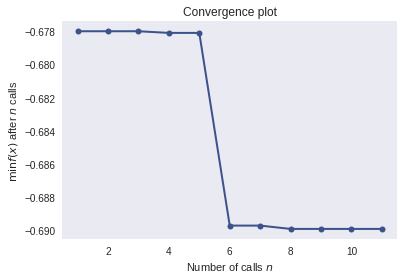

In [61]:
plot_convergence(search_result)